In [12]:
import pandas as pd
import numpy as np
import joblib
import os


from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns

## Predict

In [ ]:
data, target = load_iris(return_X_y=True, as_frame=True)
data_sc = MinMaxScaler().fit_transform(data)
model = XGBClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data_sc, target, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

## SHAP

In [ ]:
!pip install shap
import shap
shap.initjs()

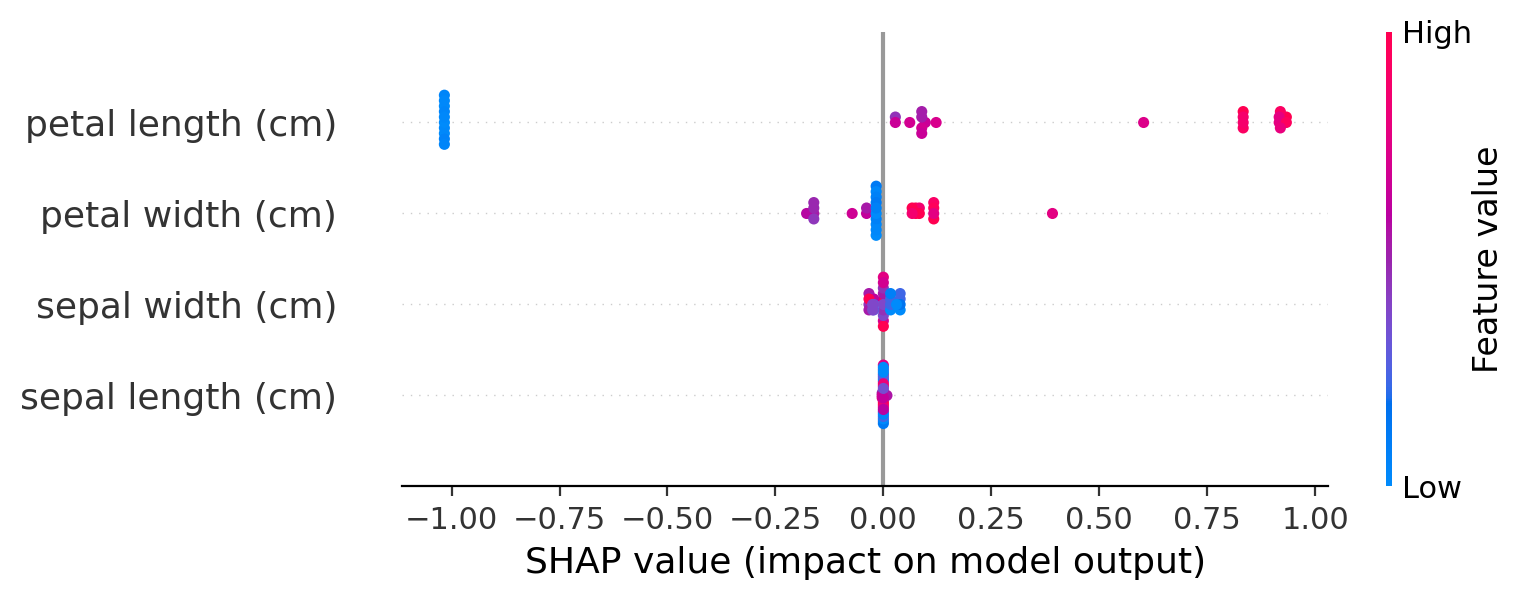

In [11]:
# model = joblib.load(path_model)

# Params
X_test = X_test # данные для теста
model = model # модель
column_names_list = data.columns.tolist() # названия колонок
dpi = 200 # качество картинки
max_display = 20 # сколько максимум фич показать на картинке

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
plt.figure(dpi=dpi, facecolor="white")
shap.summary_plot(shap_values,
                  X_test,
                  feature_names=data.columns.tolist(),
                  sort=True,
                  max_display=max_display,
                  )
plt.show()

## TSNE

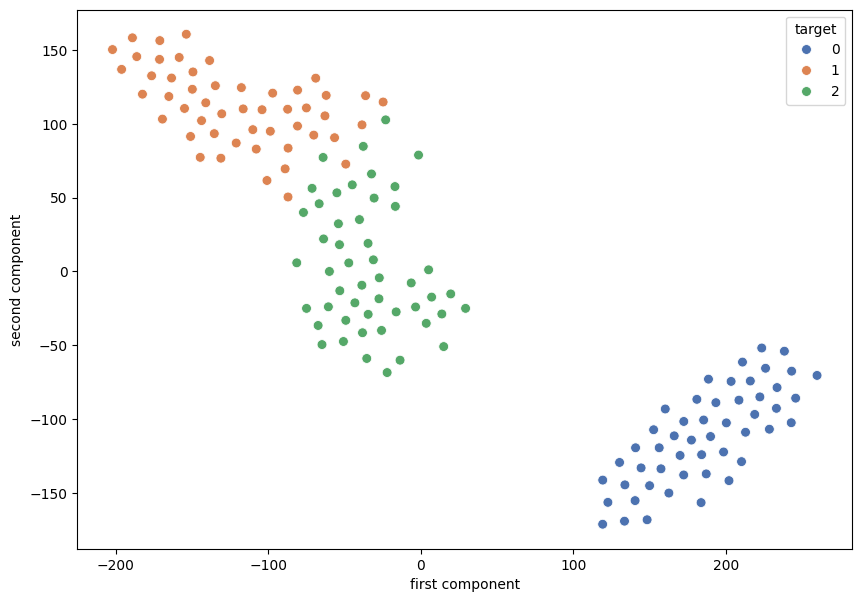

In [21]:
# Params
data_sc = data_sc # фичи
target = target # таргет
figsize_x = 10 # размер картинки по оси X
figsize_y = 7 # размер картинки по оси Y
dor_size = 50 # размер точек в пикселях
# далее идут гиперпараметры TSNE, подробнее в доке https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# здесь перечислены те, которые зачастую реально влияют на полученный результат и их стоит менять
n_components = 2
learning_rate = 800.0
perplexity = 30
early_exaggeration = 20.0


model = TSNE(
    n_components=n_components,
    learning_rate=learning_rate,
    perplexity=perplexity,
    early_exaggeration=early_exaggeration
)

x_embed = model.fit_transform(data_sc)
proc = pd.DataFrame(x_embed)

df_subset = pd.DataFrame()
df_subset['first component'] = proc[0]
df_subset['second component'] = proc[1]
df_subset['target'] = target

plt.figure(figsize=(figsize_x, figsize_y))
sns.scatterplot(
    x="first component", y="second component",
    hue="target",
    data=df_subset,
    palette="deep",
    legend="full",
    s=dor_size
)
plt.show()

In [24]:
fig = px.scatter(df_subset, x='first component', y='second component', color=target)
fig.update_traces(marker={'size': 15})
fig.show()

## PCA

In [22]:
import plotly.express as px
from sklearn.decomposition import PCA

# Params
X = data_sc # фичи
y = target # таргет


pca = PCA(n_components=2)
components = pca.fit_transform(X)
components = pd.DataFrame(components, columns=['Principle Component 0','Principle Component 1'])
fig = px.scatter(components, x='Principle Component 0', y='Principle Component 1', color=y)
fig.update_traces(marker={'size': 15})
fig.show()

## UMAP

In [ ]:
!pip install umap-learn
import umap

In [29]:
# Params
X = data_sc # фичи
y = target # таргет

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding = pd.DataFrame(embedding, columns=['Component 0','Component 1'])

fig = px.scatter(embedding, x='Component 0', y='Component 1', color=y)
fig.update_traces(marker={'size': 15})
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



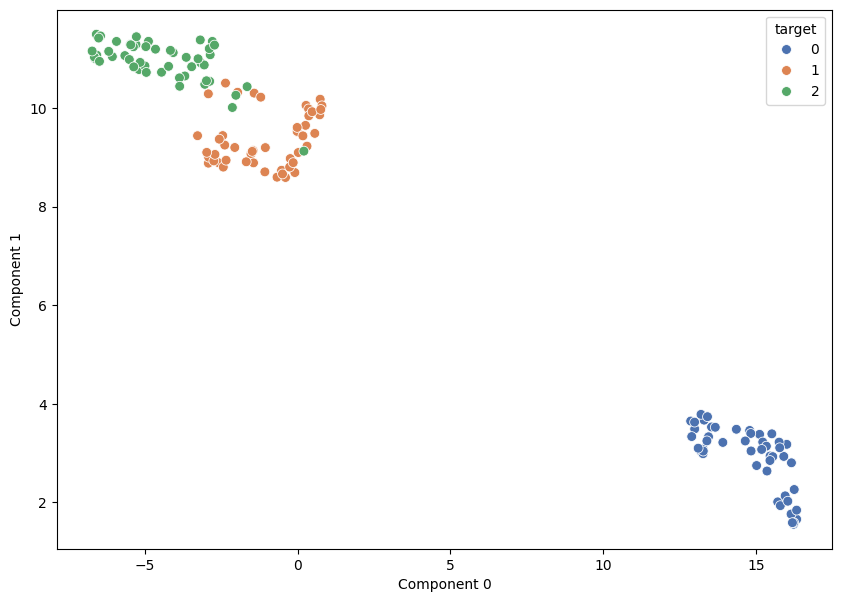

In [31]:
# Params
figsize_x = 10 # размер картинки по оси X
figsize_y = 7 # размер картинки по оси Y
dor_size = 50 # размер точек в пикселях

embedding['target'] = target
plt.figure(figsize=(figsize_x, figsize_y))
sns.scatterplot(
    x="Component 0", y="Component 1",
    hue="target",
    data=embedding,
    palette="deep",
    legend="full",
    s=dor_size
)
plt.show()

## DecisionBoundaryDisplay

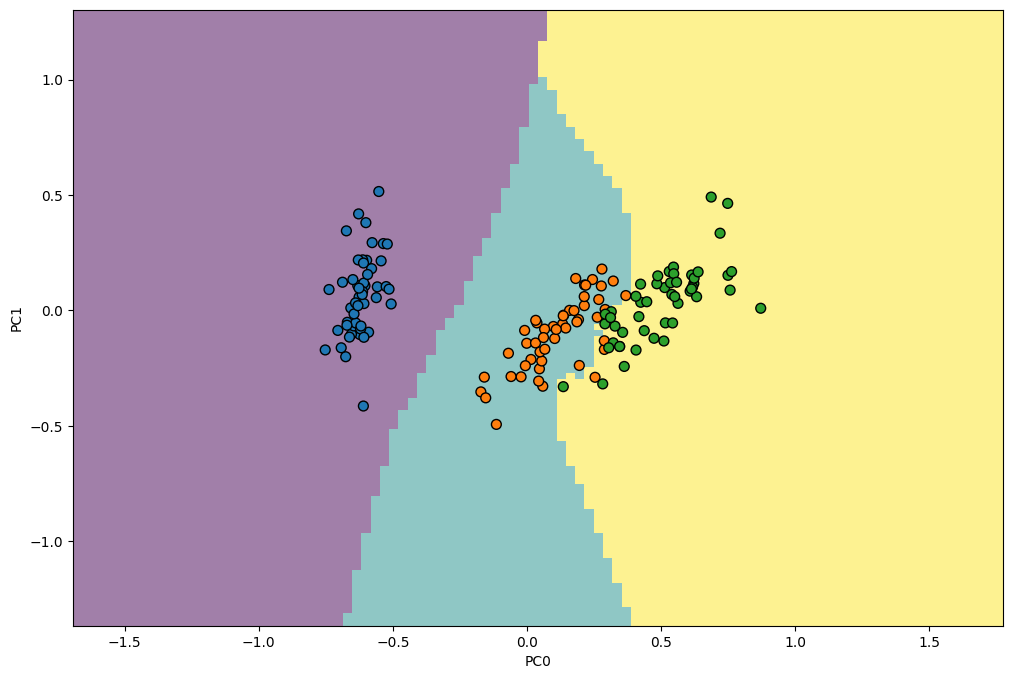

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# Params
X = data_sc # фичи после скейлинга
y = target # таргет
model = KNeighborsClassifier(n_neighbors=4) # зачастую именно алгоритм соседей, можете менять колличество соседей
dor_size = 50 # размер точек в пикселях

pca = PCA(n_components=2)
components = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(components, y, stratify=y, random_state=4, test_size=0.2)

clf = Pipeline(
    steps=[("knn", model)]
)

_, axs = plt.subplots(ncols=1, figsize=(12, 8))

clf.set_params(knn__weights="distance").fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_test,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel='PC0',
    ylabel='PC1',
    shading="auto",
    alpha=0.5,
    ax=axs,
)
scatter = disp.ax_.scatter(
    components[:, 0], components[:, 1], c=[sns.color_palette()[x] for x in target.to_frame().target],
    edgecolors="k", s=dor_size)


plt.show()